In [46]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Weather classification project

https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/data

In [47]:
weather_data = pd.read_csv('data/weather_classification_data.csv')
weather_data.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [48]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [49]:
weather_data.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


In [50]:
weather_data['Weather Type'].value_counts()

Weather Type
Rainy     3300
Cloudy    3300
Sunny     3300
Snowy     3300
Name: count, dtype: int64

In [51]:
weather_data['Weather Type'] = weather_data['Weather Type'].map({'Rainy': 1, 'Cloudy': 2, 'Sunny': 3, 'Snowy': 4})
weather_data['Weather Type']

0        1
1        2
2        3
3        3
4        1
        ..
13195    1
13196    4
13197    2
13198    4
13199    1
Name: Weather Type, Length: 13200, dtype: int64

In [52]:
# Separate features and target variable
X = weather_data.drop('Weather Type', axis=1)
y = weather_data['Weather Type']

In [53]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train

3958     1
2239     1
3608     3
6848     1
6119     2
        ..
11964    1
5191     1
5390     2
860      2
7270     1
Name: Weather Type, Length: 10560, dtype: int64

In [57]:
# Define categorical features for label encoding
categorical_features = ['Cloud Cover', 'Season', 'Location']


pipeline_categories = Pipeline([
    ('hot', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'))
])

final_transformation = ColumnTransformer(transformers=[
    ('categories', pipeline_categories, ['Cloud Cover', 'Season', 'Location'])
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0)

In [58]:
model_pipeline = IMBPipeline([ # each element in a Pipeline is mainly a step related to a different technique 
    ('trans', final_transformation),  # transformation
    ('sampler', SMOTE()), # another transformer
    ('dim_reduction', PCA(n_components=0.8)), # dimensionality reduction, if we want
    ('classifier', Perceptron()) # classifier, of course - there is a placeholder Perceptron, BUT it can be subsittuted with other model
])

In [59]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categories',
                                                  Pipeline(steps=[('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Cloud Cover', 'Season',
                                                   'Location'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [60]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression(solver='saga', multi_class='auto')],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga', random_state=42, multi_class='auto')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
]

In [61]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [62]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 48'

In [63]:
all_configs[4]

{'sampler': [None],
 'dim_reduction': [PCA()],
 'dim_reduction__n_components': [0.5, 0.7, 0.9],
 'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x119f262a0>,
 'classifier': [Perceptron()],
 'classifier__max_iter': [1, 5, 10, 15, 50, 100],
 'classifier__class_weight': [None, 'balanced']}

In [69]:
rs = RandomizedSearchCV(model_pipeline,
                        param_distributions=all_configs,
                        n_iter=len(all_configs)*5,
                        n_jobs=-1,
                        cv=2, scoring='f1_weighted')

In [70]:
scores = cross_validate(rs, X_train, y_train, scoring='f1_weighted', cv=5, return_estimator=True, verbose=3) # 3 minutes

/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/

[CV] END ......................................., score=0.658 total time=  22.8s


/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logi

[CV] END ......................................., score=0.653 total time=  18.1s


/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/pytho

[CV] END ......................................., score=0.627 total time=  12.5s


/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_mode

[CV] END ......................................., score=0.671 total time=  11.2s


/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/a

[CV] END ......................................., score=0.659 total time=  19.2s


In [71]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
LinearDiscriminantAnalysis()
LogisticRegression(C=np.float64(0.01551035387419067), class_weight='balanced',
                   multi_class='auto', penalty='l1', random_state=42,
                   solver='saga') {'C': np.float64(0.01551035387419067), 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.6575509156325331
----------
None
None
RandomForestClassifier(n_estimators=50) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, '

In [73]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.6552587611504141, F1 on test set:0.6703566654696455
F1 on training set:0.6565134532078856, F1 on test set:0.6716703589379319
F1 on training set:0.6561019753811685, F1 on test set:0.6693163578017856
F1 on training set:0.6542487532453172, F1 on test set:0.6710288946857181
F1 on training set:0.6542487532453172, F1 on test set:0.6710288946857181


In [74]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('classifier',LogisticRegression(solver='saga', penalty = 'l1', random_state=42, multi_class='auto'))
])

In [75]:
params = {
    'classifier__C': uniform(loc=15, scale=60)
}

In [76]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='f1_weighted'
)

In [77]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('categories',
                                                                               Pipeline(steps=[('hot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Cloud '
                                                                                'Cover',
                                                                                'Season',
                                                                                'Location'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(multi_class='auto',
                                                                 penalty='l1',
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   n_iter=20,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x11c9fc050>},
                   scoring='f1_weighted')

In [78]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categories',
                                                  Pipeline(steps=[('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Cloud Cover', 'Season',
                                                   'Location'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=np.float64(61.177362347372416),
                                    multi_class='auto', penalty='l1',
                                    random_state=42, solver='saga'))])

In [79]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test), average='weighted')

np.float64(0.6710288946857181)

In [80]:
cls = rs_best.best_estimator_

In [81]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                        cv=5, 
                                                        n_jobs=-1,
                                                        scoring='f1_weighted',
                                                        shuffle=False)

/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/

(0.6, 1.03)

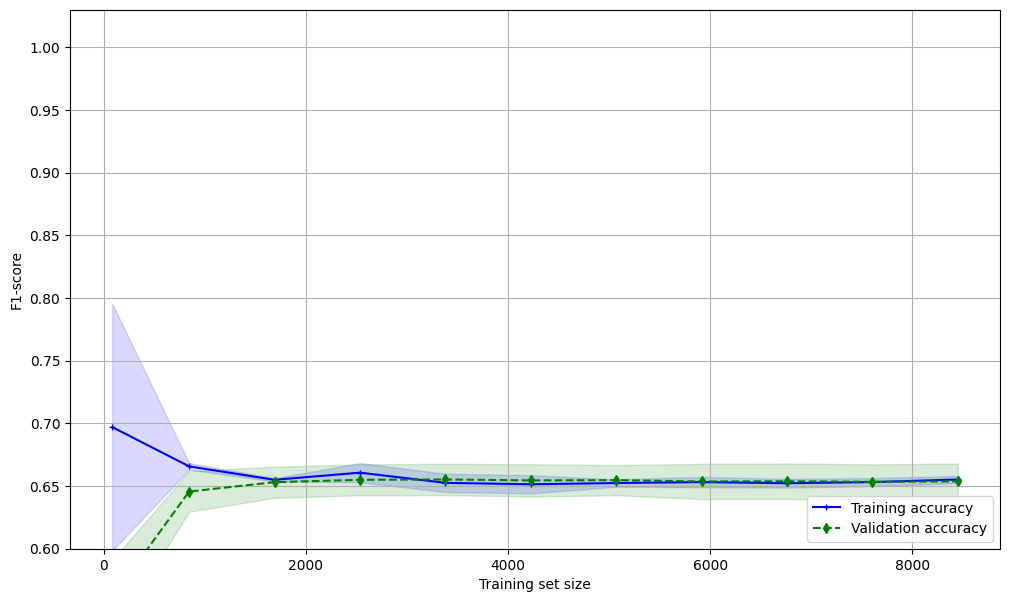

In [82]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

In [83]:
range_C = [0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_C, 
        param_name='classifier__C',
        cv=5, 
        n_jobs=-1, 
        scoring='f1_weighted'
)

/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aleksandrak/Desktop/Machine-Learning-projects/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/

(0.05, 100)

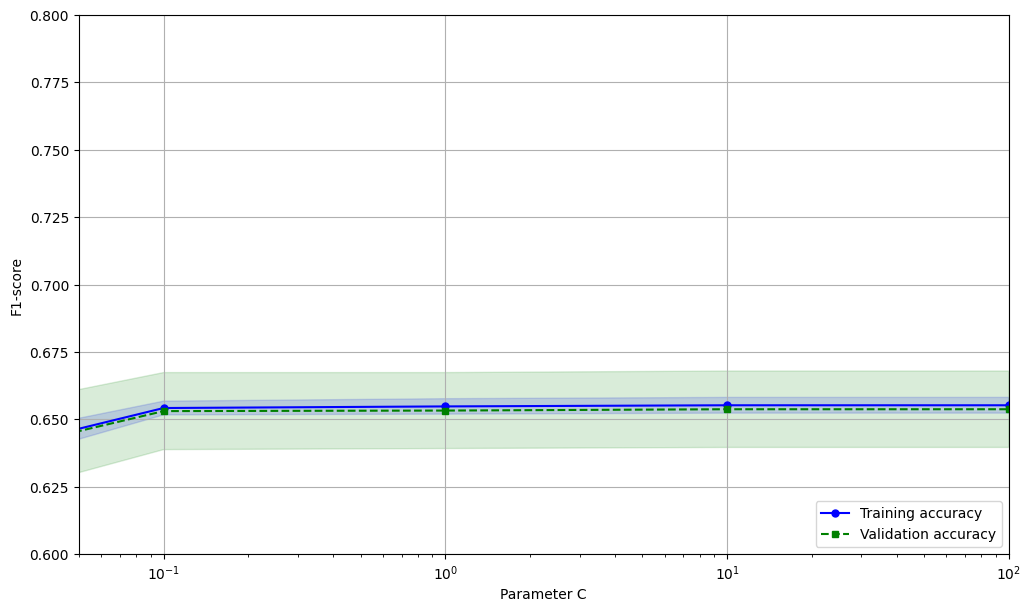

In [84]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 0.8])
ax.set_xscale('log')
ax.set_xlim([0.05,100])